<a href="https://colab.research.google.com/github/bndxn/dissertation/blob/main/rnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This example is taken from Deep Learning with Python, Chapter 6, Section 3

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [25]:
fname = '/content/drive/My Drive/Colab Notebooks/rnns/jena_climate_2009_2016.csv'

f = open(fname)
data  = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [26]:
import numpy as np

float_data = np.zeros((len(lines), len(header) -1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values

In [27]:
import pandas as pd

df = pd.read_csv(fname)

In [28]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## Problem
* Given data going *lookback* timestamp
* Sampled every *steps* timesteps
* Predict temperature in *delay* timesteps

In [29]:
lookback = 720
steps = 6
delay = 144

In [11]:
# We need to: normalise the vectors independently, and write a python generator that takes current array and yields batches from the recent past

In [30]:
# Normalising the data 
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [31]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):

    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback

    while 1:

        if shuffle:
            # rows are a random array of size (min_index+lookback) by max_index
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)

        else:
            if i + batch_size >= max_index:
                i = min_index + lookback

            rows = np.arange(i, min(i + batch_size, max_index))

            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback //step,
                            data.shape[-1]))

        targets = np.zeros((len(rows),))

        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [32]:
# Preparing the generators

lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)

val_steps  = (300000 - 200001 - lookback) // batch_size # how many steps to take from val_gen
test_steps = (len(float_data) - 300001 - lookback) // batch_size # how many steps to take from test_gen


In [33]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=10, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


500/500 [==============================] - 9s 17ms/step - loss: 1.6137 - val_loss: 0.7445
Epoch 2/10
500/500 [==============================] - 9s 17ms/step - loss: 0.4999 - val_loss: 0.3283
Epoch 3/10
500/500 [==============================] - 8s 16ms/step - loss: 0.2962 - val_loss: 0.3209
Epoch 4/10
500/500 [==============================] - 8s 16ms/step - loss: 0.2692 - val_loss: 0.3185
Epoch 5/10
500/500 [==============================] - 8s 16ms/step - loss: 0.2559 - val_loss: 0.3689
Epoch 6/10
500/500 [==============================] - 8s 17ms/step - loss: 0.2461 - val_loss: 0.3186
Epoch 7/10
500/500 [==============================] - 8s 16ms/step - loss: 0.2389 - val_loss: 0.3045
Epoch 8/10
500/500 [==============================] - 8s 16ms/step - loss: 0.2340 - val_loss: 0.3362
Epoch 9/10
500/500 [==============================] - 8s 16ms/step - loss: 0.2297 - val_loss: 0.3173
Epoch 10/10
500/500 [==============================] - 8s 16ms/step - loss: 0.2242 - val_loss: 0.3339


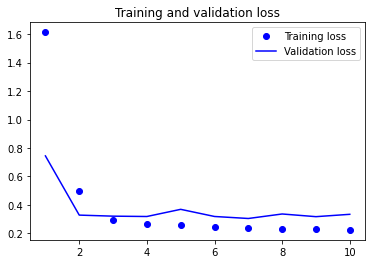

In [34]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) +1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
# GRU-based model

from keras import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps = val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


500/500 [==============================] - 14s 25ms/step - loss: 0.3085 - val_loss: 0.2692
Epoch 2/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2842 - val_loss: 0.2713
Epoch 3/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2769 - val_loss: 0.2705
Epoch 4/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2726 - val_loss: 0.2697
Epoch 5/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2673 - val_loss: 0.2647
Epoch 6/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2645 - val_loss: 0.2659
Epoch 7/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2578 - val_loss: 0.2656
Epoch 8/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2531 - val_loss: 0.2739
Epoch 9/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2480 - val_loss: 0.2676
Epoch 10/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2431 - val_los

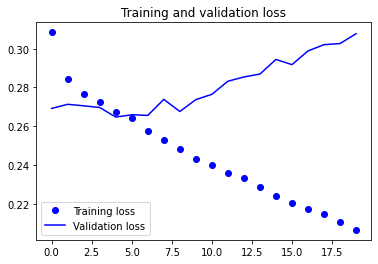

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()